The main page containing the enron data can be found at: https://www.cs.cmu.edu/~./enron/


In [178]:
import re
import numpy as np
import pandas as pd
import email
#Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('poster')
import hypergraph

Read the data into hyperedges.  We preserve order only in so far as the first element in each array is the sender.  Email addresses may appear multiple times if they were included multiple times in the header.  For example their exist cases where a given address was included in both the cc and the bcc lines of the same message.

to, cc and bcc addresses where treated the same and simply merged into a single list.

In [179]:
import os
#for root, user, file in os.walk('/Users/jchealy/Downloads/maildir/'):
root = '/Users/jchealy/Downloads/maildir/'
count =0 
edges = []
file_index = []
for user in os.listdir(root):
    #print(user)
    location = root+user+'/_sent_mail'
    if(count>2):
        break   
    if(os.path.isdir(location)):
        #print(location)
        for fname in os.listdir(location):
            file= location+'/'+fname
            #print(file)
            with open(file) as f:
                message = email.message_from_file(f)
                edge = [message['from']]
                if 'To' in message:
                    edge = edge+re.split(r'\s*,\s*', message['to'])
                if 'Cc' in message:
                    edge = edge + re.split(r'\s*,\s*', message['cc'])
                if 'Bcc' in message:
                    edge = edge + re.split(r'\s*,\s*', message['bcc'])
                edges.append(edge)
                file_index.append(file)

#Descriptive Statistics
###Edge size distribution

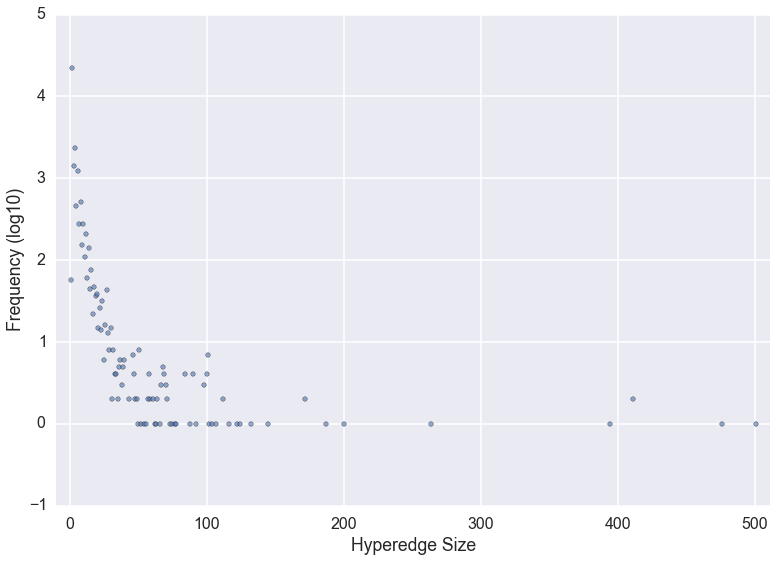

In [180]:
l = pd.Series([len(x) for x in edges])
d = l.value_counts().sort_index().reset_index()
d.columns = ['index', 'freq']
d['freq']=np.log10(d['freq'])
ax = d.plot(x='index', y='freq', kind='scatter', alpha=0.6, xlim=[-10,max(d['index'])+10])
ax.set_ylabel('Frequency (log10)')
ax.set_xlabel('Hyperedge Size')

###Number of hyperedges in email hypergraph

In [181]:
len(edges)

30109

###Number of nodes in email hypergraph

In [182]:
flat = [item for sublist in edges for item in sublist]
len(flat)
nodes = np.unique(flat)
len(nodes)

7568

###Next read the edges into Lelands library
###Then write various output functions for these structures depending on folks want to ingest

In [183]:
edges[1:10]

[['phillip.allen@enron.com', 'john.lavorato@enron.com'],
 ['phillip.allen@enron.com', 'leah.arsdall@enron.com'],
 ['phillip.allen@enron.com', 'randall.gay@enron.com'],
 ['phillip.allen@enron.com', 'greg.piper@enron.com'],
 ['phillip.allen@enron.com', 'greg.piper@enron.com'],
 ['phillip.allen@enron.com',
  'david.l.johnson@enron.com',
  'john.shafer@enron.com'],
 ['phillip.allen@enron.com', 'joyce.teixeira@enron.com'],
 ['phillip.allen@enron.com', 'mark.scott@enron.com'],
 ['phillip.allen@enron.com', 'zimam@enron.com']]

###Pawel has requested that these addresses be remapped to one up integers and output in one array per line.  To maximize code re-use I'll write that as function in the hypergraph library.

###Ingest our array of arrays into a hypergraph object

In [184]:
hg = hypergraph.Hypergraph()

In [185]:
for i, edge in enumerate(edges):
    hg.add_edge(i,edge)
    if(i%10000 == 0):
        print(i)

0
10000
20000
30000


###Recompute the edge size distribution
This is a quick example of how to access the hypergraph object.

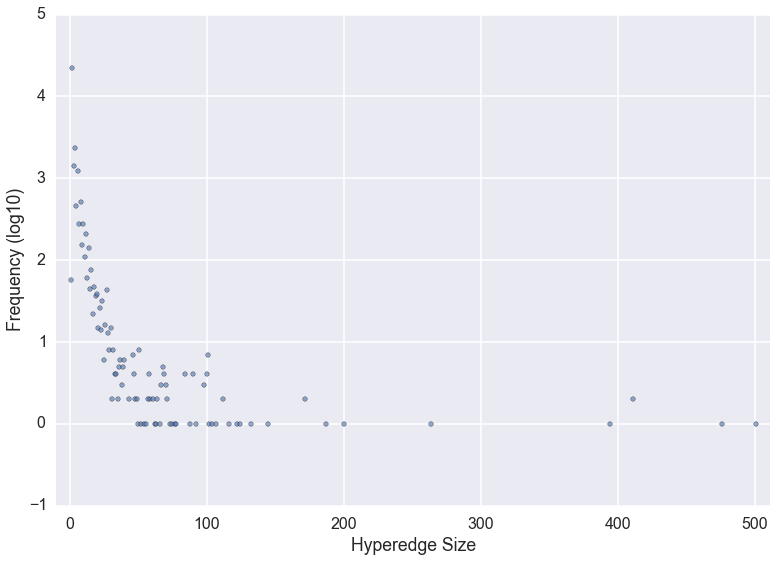

In [186]:
edge_size = pd.Series([hg.edge[x].size for x in hg.edge])
d = edge_size.value_counts().sort_index().reset_index()
d.columns = ['index', 'freq']
d['freq']=np.log10(d['freq'])
ax = d.plot(x='index', y='freq', kind='scatter', alpha=0.6, xlim=[-10,max(d['index'])+10])
ax.set_ylabel('Frequency (log10)')
ax.set_xlabel('Hyperedge Size')

Now let's look at node size, which might be refered to as degree by some.

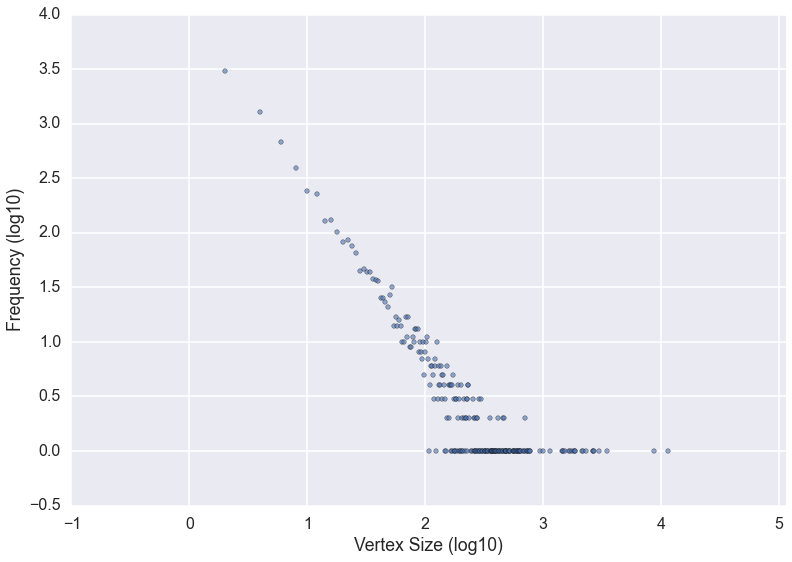

In [187]:
node_size = pd.Series([hg.node[x].size for x in hg.node])
d = node_size.value_counts().sort_index().reset_index()
d.columns = ['index', 'freq']
d['freq']=np.log10(d['freq'])
d['index']=np.log10(d['index'])
ax = d.plot(x='index', y='freq', kind='scatter', alpha=0.6, xlim=[-1,max(d['index'])+1])
ax.set_ylabel('Frequency (log10)')
ax.set_xlabel('Vertex Size (log10)')

### We can look at sender degree (number of emails sent by an individual) since the sender is currently coded as the first vertex in every hyperedge

In [188]:
sender = pd.Series([hg.edge[x].labels[0] for x in hg.edge])
sender.head()

0    phillip.allen@enron.com
1    phillip.allen@enron.com
2    phillip.allen@enron.com
3    phillip.allen@enron.com
4    phillip.allen@enron.com
dtype: object

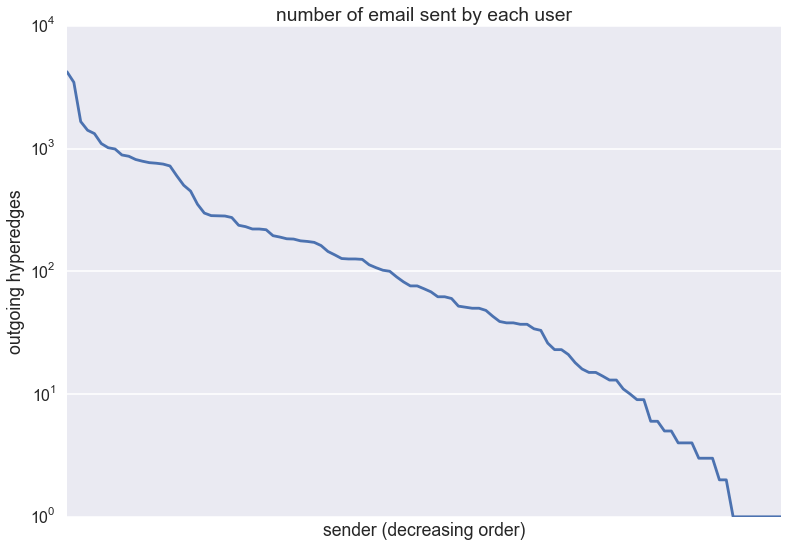

In [189]:
sender = pd.Series([hg.edge[x].labels[0] for x in hg.edge])
d = sender.value_counts().plot(kind='line', title='number of email sent by each user', logx=False, logy=True)
plt.xticks([])
plt.ylabel('outgoing hyperedges')
plt.xlabel('sender (decreasing order)')

Might be worth inducing the 2 section and overlaying the two degree distributions on each other.

### The cardinality of an edge is the number of unique nodes in the edge.  An interesting question might be which email have a cardinality which differs from their size. 

In [194]:
pd.set_option('precision',2)

In [203]:
edge_size = pd.Series([hg.edge[x].size for x in hg.edge])
edge_card = pd.Series([hg.edge[x].cardinality for x in hg.edge])
#hg.edge[[edge_size!=edge_card]]
edge_difference_index = np.where(edge_size!=edge_card)[0]
print(str(len(edge_difference_index))+" out of " + str(len(edge_size)) + " ("+
      "{:.2f}".format(len(edge_difference_index)/len(edge_size)*100)+
      "%) edges differed between cardinality and size")

4966 out of 30109 (16.49%) edges differed between cardinality and size


In [207]:
[hg.edge[x].labels for x in edge_difference_index][:5]

[array(['phillip.allen@enron.com', 'brad.mcsherry@enron.com',
        'john.lavorato@enron.com', 'hunter.shively@enron.com',
        'john.lavorato@enron.com', 'hunter.shively@enron.com'], dtype=object),
 array(['phillip.allen@enron.com', 'tim.heizenrader@enron.com',
        'tim.belden@enron.com', 'tim.belden@enron.com'], dtype=object),
 array(['phillip.allen@enron.com', 'ned.higgins@enron.com',
        'mike.grigsby@enron.com', 'mike.grigsby@enron.com'], dtype=object),
 array(['phillip.allen@enron.com', 'tara.sweitzer@enron.com',
        'brenda.flores-cuellar@enron.com', 'brenda.flores-cuellar@enron.com'], dtype=object),
 array(['phillip.allen@enron.com', 'brenda.flores-cuellar@enron.com',
        'dale.neuner@enron.com', 'dale.neuner@enron.com'], dtype=object)]

###Output in basic integer tuple format
I'll convert this into a utility function directly in the library next

In [49]:
keys = hg.nodes
values = range(len(hg.nodes))
vertex_map = dict(zip(keys,values))

filename = "enronNumericHypergraphEdgelist.txt"
file = open(filename,'w')
@np.vectorize
def vertex_mapper(x):
    return vertex_map[x]

for e in hg.edge:
    tup = vertex_mapper(hg.edge[e].labels)
    file.write(" ".join(str(elem) for elem in tup)+"\n")
    #print(" ".join(str(elem) for elem in [vertex_map[x] for x in tup]))
file.close()        

In [33]:
hg.node['tim.belden@enron.com'].labels

array([0, 128, 128, 153, 168, 186, 269, 277, 297, 297, 324, 453, 589, 1416,
       1418, 1418, 1419, 1433, 1436, 1459, 1462, 1463, 1464, 1466, 3592,
       3594, 3943, 4850, 4875, 4885, 4898, 4909, 4912, 4915, 4917, 4919,
       4929, 4929, 4931, 4944, 4946, 4948, 4956, 4957, 4980, 4980, 4984,
       4986, 4998, 5009, 5040, 5044, 5048, 5048, 5074, 5081, 5081, 5118,
       5119, 5147, 5167, 5168, 5170, 5181, 5186, 5228, 5230, 5266, 5329,
       5336, 5339, 5347, 5347, 5357, 5369, 5373, 5385, 5386, 5391, 5404,
       5406, 5430, 5438, 5511, 5554, 5571, 5594, 5639, 5639, 5715, 10885,
       11014, 11041, 11041, 11068, 11068, 11223, 11225, 11227, 11234,
       11234, 11235, 11237, 11237, 11239, 11240, 11240, 11248, 11258,
       11260, 11260, 11268, 11271, 11277, 11278, 11280, 11282, 11282,
       11294, 11295, 11295, 11304, 11320, 11325, 11337, 11340, 11341,
       11346, 11352, 11354, 11366, 11367, 11367, 11368, 11368, 11370,
       11370, 11373, 11374, 11374, 11387, 11387, 11412, 11417,